# T81-558: Applications of Deep Neural Networks
**Module 4: Training a Neural Network**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 4.1: Early Stopping and Feature Vector Encoding](https://www.youtube.com/watch?v=ATuyK_HWZgc&index=12&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 4.2: Evaluating Classification and Regression Networks](https://www.youtube.com/watch?v=hXkZqGi5mB4&index=13&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 4.3: Cross-Validation for Neural Networks](https://www.youtube.com/watch?v=SIyMm5DFwQ8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 4.4: Manual Error Calculation](https://www.youtube.com/watch?v=iMyGyZYE9Lc)

# Helpful Functions

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
import base64
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low


# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Building the Feature Vector

Neural networks require their input to be a fixed number of columns.  This is very similar to spreadsheet data.  This input must be completely numeric.  

It is important to represent the data in a way that the neural network can train from it.  In class 6, we will see even more ways to preprocess data.  For now, we will look at several of the most basic ways to transform data for a neural network.

Before we look at specific ways to preprocess data, it is important to consider four basic types of data, as defined by [Stanley Smith Stevens](https://en.wikipedia.org/wiki/Stanley_Smith_Stevens).  These are commonly referred to as the [levels of measure](https://en.wikipedia.org/wiki/Level_of_measurement):

* Character Data (strings)
    * **Nominal** - Individual discrete items, no order. For example: color, zip code, shape.
    * **Ordinal** - Individual discrete items that can be ordered.  For example: grade level, job title, Starbucks(tm) coffee size (tall, vente, grande) 
* Numeric Data
    * **Interval** - Numeric values, no defined start.  For example, temperature.  You would never say "yesterday was twice as hot as today".
    * **Ratio** - Numeric values, clearly defined start.  For example, speed.  You would say that "The first car is going twice as fast as the second."

The following code contains several useful functions to encode the feature vector for various types of data.  Encoding data:

* **encode_text_dummy** - Encode text fields, such as the iris species as a single field for each class.  Three classes would become "0,0,1" "0,1,0" and "1,0,0". Encode non-target predictors this way. Good for nominal.
* **encode_text_index** - Encode text fields, such as the iris species as a single numeric field as "0" "1" and "2".  Encode the target field for a classification this way.  Good for nominal.
* **encode_numeric_zscore** - Encode numeric values as a z-score.  Neural networks deal well with "centered" fields, zscore is usually a good starting point for interval/ratio.

*Ordinal values can be encoded as dummy or index.  Later we will see a more advanced means of encoding*

Dealing with missing data:

* **missing_median** - Fill all missing values with the median value.

Creating the final feature vector:

* **to_xy** - Once all fields are numeric, this function can provide the x and y matrixes that are used to fit the neural network.

Other utility functions:

* **hms_string** - Print out an elapsed time string.
* **chart_regression** - Display a chart to show how well a regression performs.


# Dealing with Outliers

In [2]:
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
#encode_numeric_binary(df,'mpg',20)
#df['origin'] = df['origin'].astype(str)
#encode_text_tfidf(df, 'origin')

# Drop outliers in horsepower
print("Length before MPG outliers dropped: {}".format(len(df)))
remove_outliers(df,'mpg',2)
print("Length after MPG outliers dropped: {}".format(len(df)))

print(df)

Length before MPG outliers dropped: 398
Length after MPG outliers dropped: 388
      mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0    18.0          8         307.0       130.0    3504          12.0    70   
1    15.0          8         350.0       165.0    3693          11.5    70   
2    18.0          8         318.0       150.0    3436          11.0    70   
3    16.0          8         304.0       150.0    3433          12.0    70   
4    17.0          8         302.0       140.0    3449          10.5    70   
5    15.0          8         429.0       198.0    4341          10.0    70   
6    14.0          8         454.0       220.0    4354           9.0    70   
7    14.0          8         440.0       215.0    4312           8.5    70   
8    14.0          8         455.0       225.0    4425          10.0    70   
9    15.0          8         390.0       190.0    3850           8.5    70   
10   15.0          8         383.0       170.0    3563         

## Google API Keys

Sometimes you will use external API's to obtain data.  The following examples show how to use the Google API keys to encode addresses for use with neural networks.  To use these, you will need your own Google API key.  The key I have below is not a real key, you need to put your own in there.  Google will ask for a credit card, but unless you use a very large number of lookups, there will be no actual cost.  YOU ARE NOT required to get an Google API key for this class, this only shows you how.  If you would like to get a Google API key, visit this site and obtain one for **geocode**.

[Google API Keys](https://developers.google.com/maps/documentation/embed/get-api-key)

In [3]:
GOOGLE_KEY = 'AIzaSyshdufhsdiuhfuhdfuhduhiuxbUrg'

# Other Examples: Dealing with Addresses

Addresses can be difficult to encode into a neural network.  There are many different approaches, and you must consider how you can transform the address into something more meaningful.  Map coordinates can be a good approach.  [Latitude and longitude](https://en.wikipedia.org/wiki/Geographic_coordinate_system) can be a useful encoding.  Thanks to the power of the Internet, it is relatively easy to transform an address into its latitude and longitude values.  The following code determines the coordinates of [Washington University](https://wustl.edu/):

In [4]:
import requests

address = "1 Brookings Dr, St. Louis, MO 63130"

response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(GOOGLE_KEY,address))

resp_json_payload = response.json()

if 'error_message' in resp_json_payload:
    print(resp_json_payload['error_message'])
else:
    print(resp_json_payload['results'][0]['geometry']['location'])

{'lat': 38.6482003, 'lng': -90.3050494}


If latitude and longitude are simply fed into the neural network as two features, they might not be overly helpful.  These two values would allow your neural network to cluster locations on a map.  Sometimes cluster locations on a map can be useful.  Consider the percentage of the population that smokes in the USA by state:

![Smokers by State](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_6_smokers.png "Smokers by State")

The above map shows that certain behaviors, like smoking, can be clustered by global region. 

However, often you will want to transform the coordinates into distances.  It is reasonably easy to estimate the distance between any two points on Earth by using the [great circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) between any two points on a sphere:

The following code implements this formula:

$\Delta\sigma=\arccos\bigl(\sin\phi_1\cdot\sin\phi_2+\cos\phi_1\cdot\cos\phi_2\cdot\cos(\Delta\lambda)\bigr)$

$d = r \, \Delta\sigma$

In [5]:
from math import sin, cos, sqrt, atan2, radians

# Distance function
def distance_lat_lng(lat1,lng1,lat2,lng2):
    # approximate radius of earth in km
    R = 6373.0

    # degrees to radians (lat/lon are in degrees)
    lat1 = radians(lat1)
    lng1 = radians(lng1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)

    dlng = lng2 - lng1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlng / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

# Find lat lon for address
def lookup_lat_lng(address):
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(GOOGLE_KEY,address))
    json = response.json()
    if len(json['results']) == 0:
        print("Can't find: {}".format(address))
        return 0,0
    map = json['results'][0]['geometry']['location']
    return map['lat'],map['lng']


# Distance between two locations

import requests

address1 = "1 Brookings Dr, St. Louis, MO 63130" 
address2 = "3301 College Ave, Fort Lauderdale, FL 33314"

lat1, lng1 = lookup_lat_lng(address1)
lat2, lng2 = lookup_lat_lng(address2)

print("Distance, St. Louis, MO to Ft. Lauderdale, FL: {} km".format(
        distance_lat_lng(lat1,lng1,lat2,lng2)))

Distance, St. Louis, MO to Ft. Lauderdale, FL: 1685.3102481229685 km


Distances can be useful to encode addresses as.  You must consider what distance might be useful for your dataset.  Consider:

* Distance to major metropolitan area
* Distance to competitor
* Distance to distribution center
* Distance to retail outlet

The following code calculates the distance between 10 universities and washu:

In [6]:
# Encoding other universities by their distance to Washington University

schools = [
    ["Princeton University, Princeton, NJ 08544", 'Princeton'],
    ["Massachusetts Hall, Cambridge, MA 02138", 'Harvard'],
    ["5801 S Ellis Ave, Chicago, IL 60637", 'University of Chicago'],
    ["Yale, New Haven, CT 06520", 'Yale'],
    ["116th St & Broadway, New York, NY 10027", 'Columbia University'],
    ["450 Serra Mall, Stanford, CA 94305", 'Stanford'],
    ["77 Massachusetts Ave, Cambridge, MA 02139", 'MIT'],
    ["Duke University, Durham, NC 27708", 'Duke University'],
    ["University of Pennsylvania, Philadelphia, PA 19104", 'University of Pennsylvania'],
    ["Johns Hopkins University, Baltimore, MD 21218", 'Johns Hopkins']
]

lat1, lng1 = lookup_lat_lng("1 Brookings Dr, St. Louis, MO 63130")

for address, name in schools:
    lat2,lng2 = lookup_lat_lng(address)
    dist = distance_lat_lng(lat1,lng1,lat2,lng2)
    print("School '{}', distance to wustl is: {}".format(name,dist))

School 'Princeton', distance to wustl is: 1354.4905812310371
School 'Harvard', distance to wustl is: 1670.6505836338872
School 'University of Chicago', distance to wustl is: 418.0829173700165
School 'Yale', distance to wustl is: 1508.224917173613
School 'Columbia University', distance to wustl is: 1418.1537657313474
School 'Stanford', distance to wustl is: 2780.805742296612
School 'MIT', distance to wustl is: 1672.451136482304
School 'Duke University', distance to wustl is: 1046.8063308945887
School 'University of Pennsylvania', distance to wustl is: 1307.2030819428105
School 'Johns Hopkins', distance to wustl is: 1184.3910679675719


# Training with a Validation Set and Early Stopping

**Overfitting** occurs when a neural network is trained to the point that it begins to memorize rather than generalize.  

![Training vs Validation Error for Overfitting](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_training_val.png "Training vs Validation Error for Overfitting")

It is important to segment the original dataset into several datasets:

* **Training Set**
* **Validation Set**
* **Holdout Set**

There are several different ways that these sets can be constructed.  The following programs demonstrate some of these.

The first method is a training and validation set.  The training data are used to train the neural network until the validation set no longer improves.  This attempts to stop at a near optimal training point.  This method will only give accurate "out of sample" predictions for the validation set, this is usually 20% or so of the data.  The predictions for the training data will be overly optimistic, as these were the data that the neural network was trained on.  

![Training with a Validation Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_1_train_val.png "Training with a Validation Set")


In [7]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    

Using TensorFlow backend.


Train on 112 samples, validate on 38 samples
Epoch 1/1000
 - 0s - loss: 1.3263 - val_loss: 1.2906
Epoch 2/1000
 - 0s - loss: 1.2794 - val_loss: 1.2567
Epoch 3/1000
 - 0s - loss: 1.2460 - val_loss: 1.2247
Epoch 4/1000
 - 0s - loss: 1.2107 - val_loss: 1.1960
Epoch 5/1000
 - 0s - loss: 1.1801 - val_loss: 1.1701
Epoch 6/1000
 - 0s - loss: 1.1508 - val_loss: 1.1459
Epoch 7/1000
 - 0s - loss: 1.1215 - val_loss: 1.1228
Epoch 8/1000
 - 0s - loss: 1.0963 - val_loss: 1.1018
Epoch 9/1000
 - 0s - loss: 1.0758 - val_loss: 1.0819
Epoch 10/1000
 - 0s - loss: 1.0532 - val_loss: 1.0643
Epoch 11/1000
 - 0s - loss: 1.0373 - val_loss: 1.0476
Epoch 12/1000
 - 0s - loss: 1.0190 - val_loss: 1.0318
Epoch 13/1000
 - 0s - loss: 1.0040 - val_loss: 1.0179
Epoch 14/1000
 - 0s - loss: 0.9891 - val_loss: 1.0050
Epoch 15/1000
 - 0s - loss: 0.9773 - val_loss: 0.9942
Epoch 16/1000
 - 0s - loss: 0.9670 - val_loss: 0.9834
Epoch 17/1000
 - 0s - loss: 0.9578 - val_loss: 0.9715
Epoch 18/1000
 - 0s - loss: 0.9484 - val_loss:

 - 0s - loss: 0.2953 - val_loss: 0.2580
Epoch 152/1000
 - 0s - loss: 0.2929 - val_loss: 0.2557
Epoch 153/1000
 - 0s - loss: 0.2906 - val_loss: 0.2534
Epoch 154/1000
 - 0s - loss: 0.2898 - val_loss: 0.2512
Epoch 155/1000
 - 0s - loss: 0.2863 - val_loss: 0.2491
Epoch 156/1000
 - 0s - loss: 0.2832 - val_loss: 0.2466
Epoch 157/1000
 - 0s - loss: 0.2806 - val_loss: 0.2443
Epoch 158/1000
 - 0s - loss: 0.2783 - val_loss: 0.2423
Epoch 159/1000
 - 0s - loss: 0.2760 - val_loss: 0.2403
Epoch 160/1000
 - 0s - loss: 0.2735 - val_loss: 0.2381
Epoch 161/1000
 - 0s - loss: 0.2710 - val_loss: 0.2361
Epoch 162/1000
 - 0s - loss: 0.2688 - val_loss: 0.2341
Epoch 163/1000
 - 0s - loss: 0.2668 - val_loss: 0.2319
Epoch 164/1000
 - 0s - loss: 0.2643 - val_loss: 0.2298
Epoch 165/1000
 - 0s - loss: 0.2626 - val_loss: 0.2276
Epoch 166/1000
 - 0s - loss: 0.2599 - val_loss: 0.2256
Epoch 167/1000
 - 0s - loss: 0.2574 - val_loss: 0.2235
Epoch 168/1000
 - 0s - loss: 0.2553 - val_loss: 0.2215
Epoch 169/1000
 - 0s - lo

Now that the neural network is trained, we can make predictions about the test set.  The following code predicts the type of iris for test set and displays the first five irises. 

In [8]:
from sklearn import metrics
import tensorflow as tf

pred = model.predict(x_test)
print(pred[0:5]) # print first five predictions

[[4.0973369e-03 8.7977165e-01 1.1613102e-01]
 [9.8989701e-01 1.0103002e-02 1.7175730e-09]
 [3.6760881e-07 2.0157052e-02 9.7984260e-01]
 [3.0534274e-03 8.1347972e-01 1.8346678e-01]
 [3.0218584e-03 9.0403229e-01 9.2945851e-02]]


These numbers are in scientific notation.  Each line provides the probability that the iris is one of the 3 types of iris in the data set.  For the first line, the second type of iris has a 91% probability of being the species of iris.

# Early Stopping and the Best Weights

In the previous section we used early stopping so that the training would halt once the validation set no longer saw score improvements for a number of epoch.  This number of epochs that early stopping will tolerate no improvement is called *patience*.  If the patience value is large, the neural network's error may continue to worsen while early stopping is patiently waiting.  At some point earlier in the training the optimal set of weights was obtained for the neural network.  However, at the end of training we will have the weights for the neural network that finally exhausted the patience of early stopping.  The weights of this neural network might not be bad, but it would be better to have the most optimal weights during the entire training operation.  

The code presented below does this.  An additional monitor is used and saves a copy of the neural network to **best_weights.hdf5** each time the validation score of the neural network improves.  Once training is done, we just reload this file and we have the optimal training weights that were found.

This technique is slight overkill for many of the examples for this class.  It can also introduce an occasional issue (as described in the next section).  Because of this, most of the examples in this course will not use this code to obtain the absolute best weights.  However, for the larger, more complex datasets in this course, we will save the absolute best weights as demonstrated here.


In [9]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

Train on 112 samples, validate on 38 samples
Epoch 1/1000
 - 0s - loss: 1.0611 - val_loss: 1.0936
Epoch 2/1000
 - 0s - loss: 1.0387 - val_loss: 1.0672
Epoch 3/1000
 - 0s - loss: 1.0185 - val_loss: 1.0400
Epoch 4/1000
 - 0s - loss: 0.9983 - val_loss: 1.0172
Epoch 5/1000
 - 0s - loss: 0.9834 - val_loss: 0.9984
Epoch 6/1000
 - 0s - loss: 0.9694 - val_loss: 0.9816
Epoch 7/1000
 - 0s - loss: 0.9582 - val_loss: 0.9654
Epoch 8/1000
 - 0s - loss: 0.9470 - val_loss: 0.9503
Epoch 9/1000
 - 0s - loss: 0.9353 - val_loss: 0.9359
Epoch 10/1000
 - 0s - loss: 0.9254 - val_loss: 0.9212
Epoch 11/1000
 - 0s - loss: 0.9138 - val_loss: 0.9073
Epoch 12/1000
 - 0s - loss: 0.9030 - val_loss: 0.8937
Epoch 13/1000
 - 0s - loss: 0.8923 - val_loss: 0.8800
Epoch 14/1000
 - 0s - loss: 0.8808 - val_loss: 0.8668
Epoch 15/1000
 - 0s - loss: 0.8699 - val_loss: 0.8534
Epoch 16/1000
 - 0s - loss: 0.8590 - val_loss: 0.8406
Epoch 17/1000
 - 0s - loss: 0.8490 - val_loss: 0.8283
Epoch 18/1000
 - 0s - loss: 0.8389 - val_loss:

Epoch 152/1000
 - 0s - loss: 0.2111 - val_loss: 0.1845
Epoch 153/1000
 - 0s - loss: 0.2088 - val_loss: 0.1829
Epoch 154/1000
 - 0s - loss: 0.2075 - val_loss: 0.1812
Epoch 155/1000
 - 0s - loss: 0.2051 - val_loss: 0.1797
Epoch 156/1000
 - 0s - loss: 0.2030 - val_loss: 0.1781
Epoch 157/1000
 - 0s - loss: 0.2012 - val_loss: 0.1765
Epoch 158/1000
 - 0s - loss: 0.1992 - val_loss: 0.1749
Epoch 159/1000
 - 0s - loss: 0.1981 - val_loss: 0.1734
Epoch 160/1000
 - 0s - loss: 0.1958 - val_loss: 0.1719
Epoch 161/1000
 - 0s - loss: 0.1940 - val_loss: 0.1704
Epoch 162/1000
 - 0s - loss: 0.1923 - val_loss: 0.1690
Epoch 163/1000
 - 0s - loss: 0.1905 - val_loss: 0.1677
Epoch 164/1000
 - 0s - loss: 0.1888 - val_loss: 0.1665
Epoch 165/1000
 - 0s - loss: 0.1882 - val_loss: 0.1655
Epoch 166/1000
 - 0s - loss: 0.1858 - val_loss: 0.1638
Epoch 167/1000
 - 0s - loss: 0.1838 - val_loss: 0.1624
Epoch 168/1000
 - 0s - loss: 0.1826 - val_loss: 0.1612
Epoch 169/1000
 - 0s - loss: 0.1815 - val_loss: 0.1599
Epoch 170/

# Potential Keras Issue on Small Networks and Early Stopping

You might occasionally see this error:

```
OSError: Unable to create file (Unable to open file: name = 'best_weights.hdf5', errno = 22, error message = 'invalid argument', flags = 13, o_flags = 302)
```

Usually you can just run rerun the code and it goes away.  This is an unfortunate result of saving a file each time the validation score improves (as described in the previous section).  If the errors improve two rapidly, you might try to save the file twice and get an error from these two saves overlapping.  For larger neural networks this will not be a problem because each training step will take longer, allowing for plenty of time for the previous save to complete.  Because of this potential issue, this code is not used with every neural network in this course.  

# Calculate Classification Accuracy
 
Accuracy is the number of rows where the neural network correctly predicted the target class.  Accuracy is only used for classification, not regression.

$ accuracy = \frac{c}{N} $

Where $c$ is the number correct and $N$ is the size of the evaluated set (training or validation). Higher accuracy numbers are desired.

As we just saw, by default, Keras will return the percent probability for each class. We can change these prediction probabilities into the actual iris predicted with **argmax**.

In [10]:
pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
print(pred)

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


Now that we have the actual iris flower predicted, we can calculate the percent accuracy (how many were correctly classified).

In [11]:
y_compare = np.argmax(y_test,axis=1) 
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 1.0


# Calculate Classification Log Loss

Accuracy is like a final exam with no partial credit.  However, neural networks can predict a probability of each of the target classes.  Neural networks will give high probabilities to predictions that are more likely.  Log loss is an error metric that penalizes confidence in wrong answers. Lower log loss values are desired.

The following code shows the output of predict_proba:


In [12]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model.predict(x_test)

print("Numpy array of predictions")
print(pred[0]*100)

print("As percent probability")
display(pred[0:5])

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

Numpy array of predictions
[ 0.4971 91.1698  8.333 ]
As percent probability


array([[0.005 , 0.9117, 0.0833],
       [0.9892, 0.0108, 0.    ],
       [0.    , 0.004 , 0.996 ],
       [0.0044, 0.8406, 0.155 ],
       [0.0031, 0.8727, 0.1242]], dtype=float32)

Log loss score: 0.1090184848902649


[Log loss](https://www.kaggle.com/wiki/LogarithmicLoss) is calculated as follows:

$ \text{log loss} = -\frac{1}{N}\sum_{i=1}^N {( {y}_i\log(\hat{y}_i) + (1 - {y}_i)\log(1 - \hat{y}_i))} $

The log function is useful to penalizing wrong answers.  The following code demonstrates the utility of the log function:

/Users/jheaton/miniconda3/envs/wustl/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


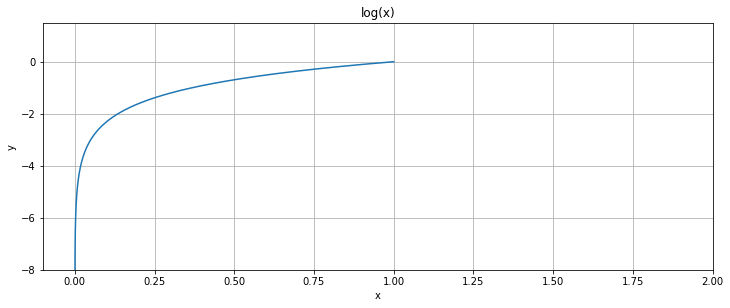

In [13]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from numpy import arange, sin, pi

#t = arange(1e-5, 5.0, 0.00001)
#t = arange(1.0, 5.0, 0.00001) # computer scientists
t = arange(0.0, 1.0, 0.00001)  # data     scientists

fig = figure(1,figsize=(12, 10))

ax1 = fig.add_subplot(211)
ax1.plot(t, np.log(t))
ax1.grid(True)
ax1.set_ylim((-8, 1.5))
ax1.set_xlim((-0.1, 2))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('log(x)')

show()

# Evaluating Regression Results

Regression results are evaluated differently than classification.  Consider the following code that trains a neural network for the [MPG dataset](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/datasets_mpg.ipynb). 

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10))
model.add(Dense(10))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


Train on 298 samples, validate on 100 samples
Epoch 1/1000
 - 0s - loss: 142034.0649 - val_loss: 22125.5094
Epoch 2/1000
 - 0s - loss: 5822.5145 - val_loss: 7864.1312
Epoch 3/1000
 - 0s - loss: 10037.8172 - val_loss: 5982.6624
Epoch 4/1000
 - 0s - loss: 2253.3492 - val_loss: 232.4389
Epoch 5/1000
 - 0s - loss: 796.3646 - val_loss: 990.3266
Epoch 6/1000
 - 0s - loss: 653.7929 - val_loss: 174.5293
Epoch 7/1000
 - 0s - loss: 277.1220 - val_loss: 275.1542
Epoch 8/1000
 - 0s - loss: 283.4258 - val_loss: 168.5874
Epoch 9/1000
 - 0s - loss: 231.6704 - val_loss: 173.7314
Epoch 10/1000
 - 0s - loss: 232.5294 - val_loss: 164.0449
Epoch 11/1000
 - 0s - loss: 225.1893 - val_loss: 165.6957
Epoch 12/1000
 - 0s - loss: 224.6920 - val_loss: 162.9912
Epoch 13/1000
 - 0s - loss: 224.6847 - val_loss: 162.3074
Epoch 14/1000
 - 0s - loss: 224.6661 - val_loss: 162.8305
Epoch 15/1000
 - 0s - loss: 220.2555 - val_loss: 160.3870
Epoch 16/1000
 - 0s - loss: 224.4560 - val_loss: 160.0171
Epoch 17/1000
 - 0s - lo

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good.  However, beyond this, there is not much more you can determine.  Low MSE values are desired.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $


In [15]:
# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

Final score (MSE): 107.88433837890625


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome. Low RMSE values are desired.

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [16]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 10.386738777160645


# Training with Cross-Validation

Cross-Validation uses a number of folds, and multiple models, to generate out of sample predictions on the entire dataset.  It is important to note that there will be one model (neural network) for each fold. Each model contributes part of the final out-of-sample prediction.

![K-Fold Crossvalidation](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_1_kfold.png "K-Fold Crossvalidation")

For new data, which is data not present in the training set, predictions from the fold models can be handled in several ways.

* Choose the model that had the highest validation score as the final model.
* Preset new data to the 5 models and average the result (this is an [ensemble](https://en.wikipedia.org/wiki/Ensemble_learning)).
* Retrain a new model (using the same settings as the cross-validation) on the entire dataset.  Train for as many epochs, and with the same hidden layer structure.

## Regression with Cross-Validation

The following code trains the MPG dataset using a 5-fold cross-validation.  The expected performance of a neural network, of the type trained here, would be the score for the generated out-of-sample predictions.

In [17]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Preprocess
cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Cross-Validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)


Fold #1
Epoch 00161: early stopping
Fold score (RMSE): 10.870452880859375
Fold #2
Epoch 00160: early stopping
Fold score (RMSE): 4.573093414306641
Fold #3
Epoch 00034: early stopping
Fold score (RMSE): 4.168812274932861
Fold #4
Epoch 00317: early stopping
Fold score (RMSE): 5.540182113647461
Fold #5
Epoch 00248: early stopping
Fold score (RMSE): 4.2834153175354
Final, out of sample score (RMSE): 6.417425632476807


## Classification with Cross-Validation

The following code trains and fits the iris dataset with Cross-Validation.  It also writes out the out of sample (predictions on the test set) results.

In [18]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation

path = "./data/"

filename_read = os.path.join(path,"iris.csv")
filename_write = os.path.join(path,"iris-out-of-sample.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print("Final score (accuracy): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)



Fold #1
Epoch 00207: early stopping
Fold score (accuracy): 1.0
Fold #2
Epoch 00255: early stopping
Fold score (accuracy): 0.9666666666666667
Fold #3
Epoch 00233: early stopping
Fold score (accuracy): 0.9666666666666667
Fold #4
Epoch 00150: early stopping
Fold score (accuracy): 0.9333333333333333
Fold #5
Epoch 00304: early stopping
Fold score (accuracy): 1.0
Final score (accuracy): 0.9733333333333334


# Training with both a Cross-Validation and a Holdout Set

If you have a considerable amount of data, it is always valuable to set aside a holdout set before you cross-validate.  This hold out set will be the final evaluation before you make use of your model for its real-world use.

![Cross Validation and a Holdout Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_hold_train_val.png "Cross Validation and a Holdout Set")

The following program makes use of a holdout set, and then still cross-validates.  

In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
filename_write = os.path.join(path,"auto-mpg-holdout.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_text_dummy(df, 'origin')

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')


# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.10) 


# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
for train, test in kf.split(x_main):        
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred) 

    # Measure accuracy
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print()
print("Cross-validated score (RMSE): {}".format(score))    
    
# Write the cross-validated prediction (from the last neural network)
holdout_pred = model.predict(x_holdout)

score = np.sqrt(metrics.mean_squared_error(holdout_pred,y_holdout))
print("Holdout score (RMSE): {}".format(score))    


Fold #1
Epoch 00059: early stopping
Fold score (RMSE): 15.734644889831543
Fold #2
Fold score (RMSE): 18.667470932006836
Fold #3
Epoch 00224: early stopping
Fold score (RMSE): 3.864037036895752
Fold #4
Epoch 00020: early stopping
Fold score (RMSE): 8.148503303527832
Fold #5
Epoch 00154: early stopping
Fold score (RMSE): 3.963421583175659

Cross-validated score (RMSE): 11.796749114990234
Holdout score (RMSE): 3.031569242477417


# Scikit-Learn Versions: model_selection vs cross_validation

Scikit-Learn changed a bit in how cross-validation is handled.  Both versions still work, but you should use the **sklearn.model_selection** import, rather than **sklearn.cross_validation**.  The following shows both the new and old forms of cross-validation.  All examples from this class will use the newer form.

The following two sections show both forms:

In [20]:
# Note: 2018-12-14: sklearn.cross_validation is now totally gone from sklearn, if the code
# below still works on your system, you REALLY need to update your software. :-)

# Older scikit-learn syntax for splits/cross-validation
# Still valid, but going away.  Do not use.
# (Note the red box warning below)

#from sklearn.cross_validation import train_test_split
#from sklearn.cross_validation import KFold

#path = "./data/"

#filename_read = os.path.join(path,"auto-mpg.csv")
#df = pd.read_csv(filename_read,na_values=['NA','?'])

#kf = KFold(len(df), n_folds=5)

#fold = 0
#for train, test in kf:        
#    fold+=1
#    print("Fold #{}: train={}, test={}".format(fold,len(train),len(test)))

In [21]:
# Newer scikit-learn syntax for splits/cross-validation
# Use this method (as shown above)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

kf = KFold(5)

fold = 0
for train, test in kf.split(df):        
    fold+=1
    print("Fold #{}: train={}, test={}".format(fold,len(train),len(test)))

Fold #1: train=318, test=80
Fold #2: train=318, test=80
Fold #3: train=318, test=80
Fold #4: train=319, test=79
Fold #5: train=319, test=79


# How Kaggle Competitions are Scored

[Kaggle](https://www.kaggle.com/) is a platform for competitive data science. Competitions are posted onto Kaggle by companies seeking the best model for their data.  Competing in a Kaggle competition is quite a bit of work, I've [competed in one Kaggle competition](https://www.kaggle.com/jeffheaton).   

Kaggle awards "tiers", such as:

* Kaggle Grandmaster
* Kaggle Master
* Kaggle Expert

Your [tier](https://www.kaggle.com/progression) is based on your performance in past competitions.  

To compete in Kaggle you simply provide predictions for a dataset that they post.  You do not need to submit any code.  Your prediction output will place you onto the [leaderboard of a competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/leaderboard/public).

![How Kaggle Competitions are Scored](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_3_kaggle.png "How Kaggle Competitions are Scored")

An original dataset is sent to Kaggle by the company.  From this dataset, Kaggle posts public data that includes "train" and "test.  For the "train" data, the outcomes (y) are provided.  For the test data, no outcomes are provided.  Your submission file contains your predictions for the "test data".  When you submit your results, Kaggle will calculate a score on part of your prediction data.  They do not publish want part of the submission data are used for the public and private leaderboard scores (this is a secret to prevent overfitting).  While the competition is still running, Kaggle publishes the public leaderboard ranks.  Once the competition ends, the private leaderboard is revealed to designate the true winners.  Due to overfitting, there is sometimes an upset in positions when the final private leaderboard is revealed.  

# Managing Hyperparameters

There are many different settings that you can use for a neural network.  These can affect performance.  The following code changes some of these, beyond their default values:

* **activation:** relu, sigmoid, tanh
* Layers/Neuron Counts
* **optimizer:** adam, sgd, rmsprop, and [others](https://keras.io/optimizers/)

In [22]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf

path = "./data/"
preprocess = False

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))



Epoch 00042: early stopping
Score (RMSE): 8.010347366333008


# Error Calculation from Scratch

We will now look at how to calculate RMSE and logloss by hand.  You will need to be able to perform this for the midterm.


## Regression

In [23]:
from sklearn import metrics
import numpy as np

predicted = [1.1,1.9,3.4,4.2,4.3]
expected = [1,2,3,4,5]

score_mse = metrics.mean_squared_error(predicted,expected)
score_rmse = np.sqrt(score_mse)
print("Score (MSE): {}".format(score_mse))
print("Score (RMSE): {}".format(score_rmse))


Score (MSE): 0.14200000000000007
Score (RMSE): 0.37682887362833556


In [24]:
score_mse = ((predicted[0]-expected[0])**2 + (predicted[1]-expected[1])**2 
+ (predicted[2]-expected[2])**2 + (predicted[3]-expected[3])**2
+ (predicted[4]-expected[4])**2)/len(predicted)
score_rmse = np.sqrt(score_mse)
    
print("Score (MSE): {}".format(score_mse))
print("Score (RMSE): {}".format(score_rmse))

Score (MSE): 0.14200000000000007
Score (RMSE): 0.37682887362833556


## Classification

We will now look at how to calculate a logloss by hand. For this we look at a binary prediction. The expected is always 0 or 1. The predicted is some number between 0-1 that indicates the probability true (1). Therefore, a prediction of 1.0 is completely correct if the expected is 1 and completely wrong if the expected is 0.

In [25]:
from sklearn import metrics

expected = [1,1,0,0,0]
predicted = [0.9,0.99,0.1,0.05,0.06]

print(metrics.log_loss(expected,predicted))

0.06678801305495843


Now we attempt to calculate the same logloss manually.

In [26]:
import numpy as np

score_logloss = (np.log(1.0-np.abs(expected[0]-predicted[0]))+\
np.log(1.0-np.abs(expected[1]-predicted[1]))+\
np.log(1.0-np.abs(expected[2]-predicted[2]))+\
np.log(1.0-np.abs(expected[3]-predicted[3]))+\
np.log(1.0-np.abs(expected[4]-predicted[4])))\
*(-1/len(predicted))

print(f'Score Logloss {score_logloss}')

Score Logloss 0.06678801305495843


# Module 4 Assignment

You can find the first assignment here: [assignment 4](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class1.ipynb)